<a href="https://cognitiveclass.ai"><img src = "https://imagenes.20minutos.es/files/article_amp/uploads/imagenes/2021/01/28/corruption-2727571-1280-1.png" width = 400> </a>

<h1 align=center><font size = 6>Fake news detection through Machine Learning</font></h1>

## Indice

<div class="alert alert-block alert-info" style="margin-top: 20px">

1. [Introduction](#1)<br>
2. [Data adquisition and cleaning](#2)<br>
    1. [Data Cleaning](#21)
    2. [Data Wrangling / Preprocessing](#22)
    3. [Feature Selection](#23)
    4. [Final Dataframe](#24)
3. [Exploratory data Analysis (EDA)](#3) <br>
    1. [Descriptive Statistical Analysis](#31)
    2. [Correlation and Causation](#32)
    3. [Word Cloud](#33)
    4. [Grouping](#34)
    5. [ANOVA](#35)
4. [Text Representation](#4) <br>
    1. [GloVE](#41)
    2. [Word Embedding](#42)
6. [Model Development](#5) <br>
    1. [Logistic Regresssion](#51)
    2. [Neural Networks](#52)
6. [Model Evaluation and Refinement](#6) <br>
7. [Results](#7) <br>
8. [Conclusion](#8) <br> 
</div>
<hr>

## Introduction <a id="1"></a>

Como se menciona en el titulo, vamos a diseñar un modelo de predicción orientado a la detección de noticias falsas. Para esta tarea emplearemos dos formas diferentes de representar palabras y utilizaremos dos modelos logísticos diferentes. A diferencia de proyectos anteriores, vamos a trabajar con dos features que son de tipo texto, añadiendo asi algo de complejidad extra al proyecto.

Nuestro objetivo será comparar resultados entre representaciones diferentes y obtener un clasificador que realice de forma correcta la clasificación.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import missingno as msno
import regex as re

<hr>

## 2. Data adquisition and cleaning<a id="2"></a>

Primero de todo, obtendremos el conjunto de datos.

In [3]:
df_fake = pd.read_csv('./Data/Fake.csv')
df_real = pd.read_csv('./Data/True.csv')

Como se observa, los datos estan divididos en dos conjuntos de datos dependiendo de la clase, es por ello que vamos a unirlos para poder trabajar con mas comodidad.

In [4]:
df_fake["label"] = "fake"
df_real["label"] = "real"
df_news = pd.concat([df_fake,df_real]).sample(frac=1)
df_news.reset_index(drop=True, inplace=True)

In [5]:
df_news

,title,text,subject,date,label
0,Palestinian gunman kills three Israeli guards ...,"HAR ADAR, West Bank (Reuters) - A Palestinian ...",worldnews,"September 26, 2017",real
1,3 CONSERVATIVE CELEBRITIES Visited Trump Last ...,"Ted Nugent is all smiles, as he s pictured wit...",left-news,"Apr 20, 2017",fake
2,Bone fragments found in Mexico to be tested fo...,MEXICO CITY (Reuters) - Mexican authorities sa...,worldnews,"December 6, 2017",real
3,Republicans Now Trying To Draft Billionaire M...,A group of desperate republicans which include...,News,"May 15, 2016",fake
4,Trump’s Idiot Press Secretary Tweeted Out His...,When President Asterisk assured us he was asse...,News,"January 26, 2017",fake
...,...,...,...,...,...
44893,FERGUSON FLAMETHROWER COMES OUT OF HIDING: Sla...,Holder should be making his baseless remarks f...,left-news,"Oct 30, 2015",fake
44894,Street Performer Will Let You Punch ‘Donald T...,A street performer based in New York City is g...,News,"March 20, 2016",fake
44895,Hungary not planning to move Israeli embassy t...,BUDAPEST (Reuters) - Hungary is not planning t...,worldnews,"December 11, 2017",real
44896,Poland ready to defend migration stance in EU ...,WARSAW (Reuters) - Poland is ready to defend i...,worldnews,"December 7, 2017",real


### 2.1 Data Cleaning<a id="21"></a>
Es importante mantener solo los features que más nos interesan, es por ello que vamos a eliminar todo lo que no este relacionado con el texto. Ya que la naturaleza de esta tarea es la clasificación mediante el texto. Del mismo modo, tenemos que eliminar los atributos que tengan muchos valores nulos.

<AxesSubplot:>

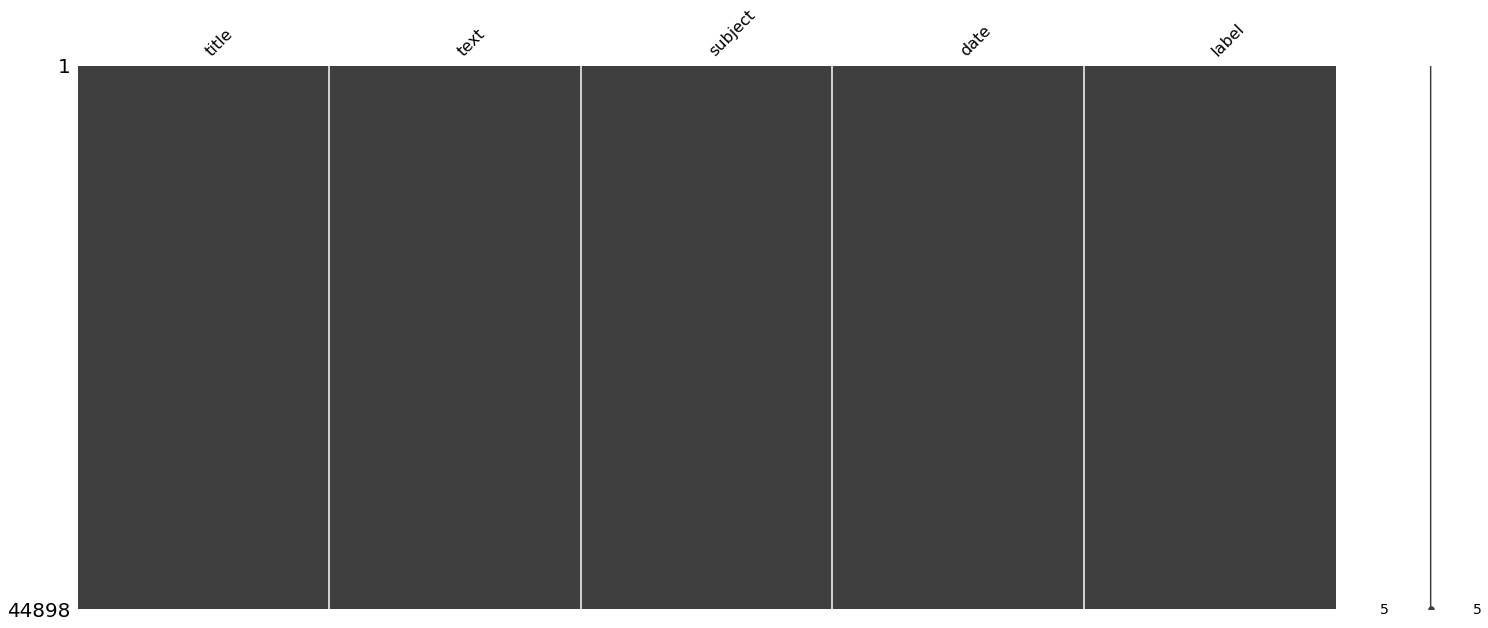

In [6]:
msno.matrix(df_news)

Como podemos observar, no encontramos valores nulos, es por ello que no es necesario eliminar columnas por falta de valores.

###  2.2 Data Wrangling / Preprocessing<a id="22"></a>
El data Wrangling es el proceso de transformar y mappear los datos a un formato estandar. En nuestro caso, al estar trabajando con texto, intentaremos normalizar los datos intentando perder la menor cantidad de información.
Para ello es posible que generemos nuevas columnas a partir de la información extraida en el texto. Esta parte corresponde una parte importante del trabajo.,

In [7]:
df_news

,title,text,subject,date,label
0,Palestinian gunman kills three Israeli guards ...,"HAR ADAR, West Bank (Reuters) - A Palestinian ...",worldnews,"September 26, 2017",real
1,3 CONSERVATIVE CELEBRITIES Visited Trump Last ...,"Ted Nugent is all smiles, as he s pictured wit...",left-news,"Apr 20, 2017",fake
2,Bone fragments found in Mexico to be tested fo...,MEXICO CITY (Reuters) - Mexican authorities sa...,worldnews,"December 6, 2017",real
3,Republicans Now Trying To Draft Billionaire M...,A group of desperate republicans which include...,News,"May 15, 2016",fake
4,Trump’s Idiot Press Secretary Tweeted Out His...,When President Asterisk assured us he was asse...,News,"January 26, 2017",fake
...,...,...,...,...,...
44893,FERGUSON FLAMETHROWER COMES OUT OF HIDING: Sla...,Holder should be making his baseless remarks f...,left-news,"Oct 30, 2015",fake
44894,Street Performer Will Let You Punch ‘Donald T...,A street performer based in New York City is g...,News,"March 20, 2016",fake
44895,Hungary not planning to move Israeli embassy t...,BUDAPEST (Reuters) - Hungary is not planning t...,worldnews,"December 11, 2017",real
44896,Poland ready to defend migration stance in EU ...,WARSAW (Reuters) - Poland is ready to defend i...,worldnews,"December 7, 2017",real


In [8]:
df_fake["text"][3]

'On Christmas day, Donald Trump announced that he would  be back to work  the following day, but he is golfing for the fourth day in a row. The former reality show star blasted former President Barack Obama for playing golf and now Trump is on track to outpace the number of golf games his predecessor played.Updated my tracker of Trump s appearances at Trump properties.71 rounds of golf including today s. At this pace, he ll pass Obama s first-term total by July 24 next year. https://t.co/Fg7VacxRtJ pic.twitter.com/5gEMcjQTbH  Philip Bump (@pbump) December 29, 2017 That makes what a Washington Post reporter discovered on Trump s website really weird, but everything about this administration is bizarre AF. The coding contained a reference to Obama and golf:  Unlike Obama, we are working to fix the problem   and not on the golf course.  However, the coding wasn t done correctly.The website of Donald Trump, who has spent several days in a row at the golf course, is coded to serve up the fo

In [9]:
df_real["text"][3]

'WASHINGTON (Reuters) - Trump campaign adviser George Papadopoulos told an Australian diplomat in May 2016 that Russia had political dirt on Democratic presidential candidate Hillary Clinton, the New York Times reported on Saturday. The conversation between Papadopoulos and the diplomat, Alexander Downer, in London was a driving factor behind the FBI’s decision to open a counter-intelligence investigation of Moscow’s contacts with the Trump campaign, the Times reported. Two months after the meeting, Australian officials passed the information that came from Papadopoulos to their American counterparts when leaked Democratic emails began appearing online, according to the newspaper, which cited four current and former U.S. and foreign officials. Besides the information from the Australians, the probe by the Federal Bureau of Investigation was also propelled by intelligence from other friendly governments, including the British and Dutch, the Times said. Papadopoulos, a Chicago-based inte

Despues de visualizar varias instancias de diferente clase, se han observado diferencias:
1. **Longitud:** Las noticias reales tienden a ser más largas.
2. **Menciones:** Las noticias falsas tienden a tener @ de twitter, lo cual hace que no sea una fuente muy fiable.
3. **URL:** Las noticias falsas tienden a tener mas URL que las verdaderas.

### 1. Longitud en base a la clase

In [10]:
def count_word_number(phrase):
    return len(phrase.split())

In [11]:
# Añadir una columna con la longitud de la frase.
df_fake['len'] = df_fake.apply(lambda row : count_word_number(row['text']), axis = 1)
df_real['len'] = df_real.apply(lambda row : count_word_number(row['text']), axis = 1)

<BarContainer object of 2 artists>

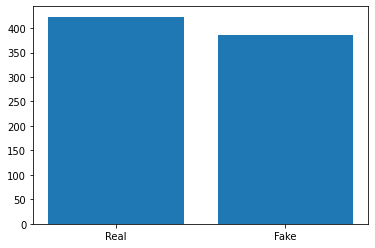

In [12]:
plt.bar(["Real","Fake"], [df_fake['len'].mean(),df_real['len'].mean()])

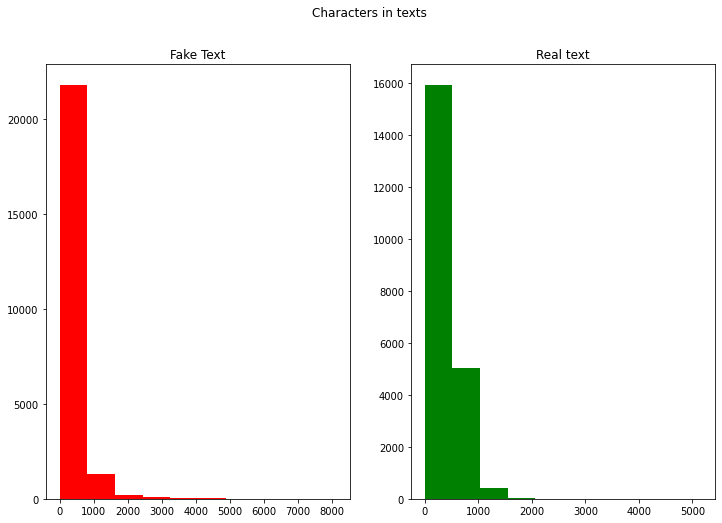

In [13]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(12,8))
ax1.hist(df_fake['len'],color='red')
ax1.set_title('Fake Text')
ax2.hist(df_real["len"],color='green')
ax2.set_title('Real text')
fig.suptitle('Characters in texts')
plt.show()

### 2. Menciones

Como hemos mencionado anteriormente, es muy común utilizar menciones en redes sociales, es por ello que las noticias extraidas directamente de estas tienden a ser falsas.

In [14]:
def count_twitters_user(df):
    twitter_username_re = re.compile(r'@([A-Za-z0-9_]+)')
    count = 0
    list_ = []
    for text in df['text']:
        count += len(re.findall(twitter_username_re, text))
    return count

<BarContainer object of 2 artists>

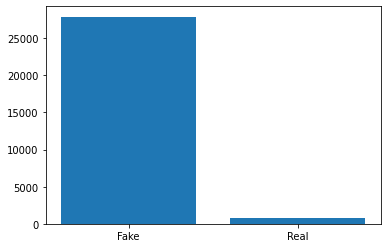

In [15]:
plt.bar(["Fake","Real"],[count_twitters_user(df_fake),count_twitters_user(df_real)])

Como se puede observar, existe una clara correlación entre la clase y la cantidad de menciones que se realizan en una noticia. Para analizar la corelación, vamos a usar Analysis of Variance (ANOVA)

### 3. URL

In [16]:
def count_url(df):
    url_re = re.compile(r'(http|ftp|https):\/\/([\w_-]+(?:(?:\.[\w_-]+)+))([\w.,@?^=%&:\/~+#-]*[\w@?^=%&\/~+#-])')
    count = 0
    list_ = []
    for text in df['text']:
        count += len(re.findall(url_re, text))
    return count

def count_mention_text(text):
    twitter_username_re = re.compile(r'@([A-Za-z0-9_]+)')
    count = len(re.findall(twitter_username_re, text))
    return count

<BarContainer object of 2 artists>

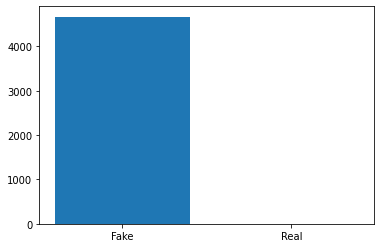

In [17]:
plt.bar(["Fake","Real"],[count_url(df_fake),count_url(df_real)])

## Adaptación de los datos<a name="moldaketa"></a>
### Hemos dividido el preprocessing en diez pasos diferentes:
1. Borrar las URL
2. Pasar todo a minúsculas
3. Quitar los stopwords
4. Quitar las marcas de puntuacion
5. Corregir palabras
6. Lemmanization
7. Corregir palabras

### 1.Borrar las URL
En las noticias podemos encontrar URL-s las cuales no no son de utilidad. Es por ello que vamos a eliminarlas. Del mismo modo, sabemos que las URL son indicadores de la veracidad de la noticia, es por ello que este valor vamos a guardarlo en una columna aparte.

In [ ]:
def remove_urls(text):
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    return url_pattern.sub(r'', text)

In [ ]:
df["OriginalTweet"] = df["OriginalTweet"].apply(lambda text: remove_urls(text))

### 2. Pasar todo a minusculas

Para que sea mas sencillo el procesamiento del texto, vamos a trasnformar todas las frases a minusculas.

In [ ]:
df["OriginalTweet"] = df["OriginalTweet"].str.lower()

### 3. Quitar los stopwords

Las conocidas como "palabras vacias" son aquellas que no nos van a aportar ninguna información, es por ello que vamos a eliminaras.


In [ ]:
STOPWORDS = set(stopwords.words('english'))
STOPWORDS.add('u')
def remove_stopwords(text):
    """custom function to remove the stopwords"""
    return " ".join([word for word in str(text).split() if word not in set(stopwords.words('english'))])

### 4. Quitar las marcas de puntuacion

Las marcas de puntuación no son relevantes, por tanto vamos a eliminarlo.

In [25]:
def remove_punctuation(text:str):
    """custom function to remove the punctuation"""
    PUNCT_TO_REMOVE = string.punctuation
    PUNCT_TO_REMOVE += 'â’'
    spaces = ''
    for i in range(len(PUNCT_TO_REMOVE)):
        spaces += ' '
    return text.translate(bytes.maketrans(PUNCT_TO_REMOVE, spaces))


In [ ]:
df["OriginalTweet"] = df["OriginalTweet"].apply(lambda text: remove_punctuation(text))

### 5. Corregir palabras

In [ ]:
df['OriginalTweet'] = df['OriginalTweet'].map(lambda x: re.sub('[^A-Za-z ]+', '', x))

In [ ]:
spell = SpellChecker()
def correct_spellings(text):
    corrected_text = []
    misspelled_words = spell.unknown(text.split())
    for word in text.split():
        if word in misspelled_words:
            corrected_text.append(spell.correction(word))
        else:
            corrected_text.append(word)
    return " ".join(corrected_text)

In [ ]:
df["OriginalTweet"] = df["OriginalTweet"].apply(lambda text: correct_spellings(text))

### 6. Lemmanization
En este proceso, lemmanizamos las palabras, lo cual trata de eliminar las posibles conjugaciones. Mas información en el siguiente link: https://en.wikipedia.org/wiki/Lemmatisation

In [ ]:
lemmatizer = WordNetLemmatizer()
def lemmatize_words(text):
    return " ".join([lemmatizer.lemmatize(word) for word in text.split()])



In [ ]:
df["OriginalTweet"] = df["OriginalTweet"].apply(lambda text: lemmatize_words(text))

### 7. Corregir palabras

Es posible que despues de todo este proceso, algunas palabras se hayan "corrompido", es por eso que vamos a volver a corregirlas.

In [26]:
spell = SpellChecker()
def correct_spellings(text):
    corrected_text = []
    misspelled_words = spell.unknown(text.split())
    for word in text.split():
        if word in misspelled_words:
            corrected_text.append(spell.correction(word))
        else:
            corrected_text.append(word)
    return " ".join(corrected_text)

NameError: name 'SpellChecker' is not defined

In [ ]:
df['OriginalTweet'] = df['OriginalTweet'].map(lambda x: re.sub('[^A-Za-z ]+', '', x))

### 2.3 Feature Selection<a id="23"></a>
En este apartado vamos a seleccionar los atributos que nos interesan para nuestro conjunto de datos.


In [18]:
df_news.drop(["subject","date"],axis=1,inplace=True)

Primero eliminaremos estas dos columnas originales del conjunto de datos, ya que no nos interesan para la tarea a realizar.

Por otro lado, hemos observado de forma superficial la correlación entre la clase y la cantidad de menciones, es por ello que vamos añadirlo al conjunto de datos. Este atributo es valido debido a que está extraido directamente del texto.

In [19]:
df_news['has_mentions'] = df_news.apply(lambda row : count_mention_text(row['text'])>1, axis = 1)

### 2.4 Final Dataframe <a id="24"></a>

In [20]:
df_news.to_csv("./Data/news.csv",index=False)

<hr>

## Exploratory data Analysis (EDA) <a id="3">
    
En este apartado analizaremos los datos y sacaramos información que nos será de relevancia.

In [21]:
df = pd.read_csv("./Data/news.csv")

In [22]:
df.loc[(df.label == 'real'),'label']=1  
df.loc[(df.label == 'fake'),'label']=0
df.loc[(df.has_mentions == 'True'),'has_mentions']=1  
df.loc[(df.has_mentions == 'False'),'has_mentions']=0

De este modo damos un valor numerico a la clase a predecir, lo cambiaremos mas adelante, pero por ahora lo tendremos como numerico para las métricas.

### Descriptive Statistical Analysis<a id="31">

### Correlation and Causation<a id="32">

In [23]:
df

,title,text,label,has_mentions
0,Palestinian gunman kills three Israeli guards ...,"HAR ADAR, West Bank (Reuters) - A Palestinian ...",1,False
1,3 CONSERVATIVE CELEBRITIES Visited Trump Last ...,"Ted Nugent is all smiles, as he s pictured wit...",0,False
2,Bone fragments found in Mexico to be tested fo...,MEXICO CITY (Reuters) - Mexican authorities sa...,1,False
3,Republicans Now Trying To Draft Billionaire M...,A group of desperate republicans which include...,0,False
4,Trump’s Idiot Press Secretary Tweeted Out His...,When President Asterisk assured us he was asse...,0,True
...,...,...,...,...
44893,FERGUSON FLAMETHROWER COMES OUT OF HIDING: Sla...,Holder should be making his baseless remarks f...,0,False
44894,Street Performer Will Let You Punch ‘Donald T...,A street performer based in New York City is g...,0,True
44895,Hungary not planning to move Israeli embassy t...,BUDAPEST (Reuters) - Hungary is not planning t...,1,False
44896,Poland ready to defend migration stance in EU ...,WARSAW (Reuters) - Poland is ready to defend i...,1,False


In [24]:
df['label']=np.float64(df['label'])
df['has_mentions']=np.fl oat64(df['has_mentions'])
df['has_mentions'].corr(df['label'])

-0.26349296331848926

De este modo comprobamos que nuestra suposición no era la mas correcta, ya que no hay una clara correspondencia entre estos dos atributos.

### Word Cloud<a id="33">

### Grouping<a id="34">

,n_mentions
n_mentions,1.0


### ANOVA<a id="35">

<hr>

# Text Representation <a id="4">

Primero de todo, prepararemos el conjunto de datos para poder realizar la vectorización de forma adecuada, preprocesando y limpiando el texto.

## TF-IDF <a id="41">

## Word Embedding <a id="42">

In [13]:
import gensim.downloader as apix
model = api.load("glove-twitter-25")
model.most_similar(positive=['fruit', 'flower'], topn=3)

KeyboardInterrupt: 

In [16]:
model.most_similar('twitter')

[('facebook', 0.948005199432373),
 ('tweet', 0.9403423070907593),
 ('fb', 0.9342359900474548),
 ('instagram', 0.9104822874069214),
 ('chat', 0.8964963555335999),
 ('hashtag', 0.8885936141014099),
 ('tweets', 0.8878159523010254),
 ('tl', 0.8778461217880249),
 ('link', 0.8778210878372192),
 ('internet', 0.8753897547721863)]

<hr>

# Model Development <a id="5">